In [109]:
import pandas as pd
import numpy as np
import glob
import os
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
import xgboost as xgb
from sklearn.svm import SVC
import joblib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [113]:
def cargar_datos(directorio):
    data = []
    etiquetas = []
    for carpeta in os.listdir(directorio):
        subdirectorio = os.path.join(directorio, carpeta, 'csv')
        
        for archivo in glob.glob(os.path.join(subdirectorio, '*.csv')):
            df = pd.read_csv(archivo)
            data.append(df)
            etiquetas.append(carpeta)
    return data, etiquetas

In [115]:
def normalizar_coordenadas(df):
    # Obtener las coordenadas promedio de las caderas
    cadera_derecha = df[df['landmark_index'] == 23][['x', 'y', 'z']].mean()
    cadera_izquierda = df[df['landmark_index'] == 24][['x', 'y', 'z']].mean()
    cadera_centro = (cadera_derecha + cadera_izquierda) / 2
    
    # Normalizar restando las coordenadas de la cadera central
    df['x'] -= cadera_centro['x']
    df['y'] -= cadera_centro['y']
    df['z'] -= cadera_centro['z']
    
    # Normalización por el tamaño del torso (distancia entre hombros 11 y 12)
    hombro_derecho = df[df['landmark_index'] == 11][['x', 'y', 'z']].mean()
    hombro_izquierdo = df[df['landmark_index'] == 12][['x', 'y', 'z']].mean()
    torso_tamano = np.linalg.norm(hombro_derecho - hombro_izquierdo)
    
    df['x'] /= torso_tamano
    df['y'] /= torso_tamano
    df['z'] /= torso_tamano
    
    return df

In [117]:
# Filtrar las coordenadas
def filtrar_datos(df):
    df['x'] = gaussian_filter1d(df['x'], sigma=2)
    df['y'] = gaussian_filter1d(df['y'], sigma=2)
    df['z'] = gaussian_filter1d(df['z'], sigma=2)
    return df

In [119]:
# Calcular el ángulo entre tres puntos
def calcular_angulo(p1, p2, p3):
    vector1 = p1 - p2
    vector2 = p3 - p2
    cos_theta = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    angulo = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angulo)

In [121]:
# Generación de características agregadas
def generar_caracteristicas(df):
    # Articulaciones clave: hombros, codos, y caderas
    articulaciones_clave = [11, 12, 13, 14, 15, 16, 23, 24]
    
    velocidades = []
    angulos_codo_derecho = []
    angulos_codo_izquierdo = []
    angulos_tronco = []
    
    for i in range(1, len(df)):
        fila_actual = df[df['frame'] == i]
        fila_anterior = df[df['frame'] == i - 1]
        
        # Calcular velocidades
        for articulacion in articulaciones_clave:
            actual = fila_actual[fila_actual['landmark_index'] == articulacion]
            anterior = fila_anterior[fila_anterior['landmark_index'] == articulacion]
            
            if not actual.empty and not anterior.empty:
                vel_x = actual['x'].values[0] - anterior['x'].values[0]
                vel_y = actual['y'].values[0] - anterior['y'].values[0]
                vel_z = actual['z'].values[0] - anterior['z'].values[0]
                velocidad = np.sqrt(vel_x**2 + vel_y**2 + vel_z**2)
                velocidades.append(velocidad)

        # Calcular ángulos
        hombro_derecho = fila_actual[fila_actual['landmark_index'] == 11][['x', 'y', 'z']].values
        codo_derecho = fila_actual[fila_actual['landmark_index'] == 13][['x', 'y', 'z']].values
        muneca_derecha = fila_actual[fila_actual['landmark_index'] == 15][['x', 'y', 'z']].values
        
        if hombro_derecho.size > 0 and codo_derecho.size > 0 and muneca_derecha.size > 0:
            angulo_codo_derecho = calcular_angulo(hombro_derecho[0], codo_derecho[0], muneca_derecha[0])
            angulos_codo_derecho.append(angulo_codo_derecho)
        
        hombro_izquierdo = fila_actual[fila_actual['landmark_index'] == 12][['x', 'y', 'z']].values
        codo_izquierdo = fila_actual[fila_actual['landmark_index'] == 14][['x', 'y', 'z']].values
        muneca_izquierda = fila_actual[fila_actual['landmark_index'] == 16][['x', 'y', 'z']].values
        
        if hombro_izquierdo.size > 0 and codo_izquierdo.size > 0 and muneca_izquierda.size > 0:
            angulo_codo_izquierdo = calcular_angulo(hombro_izquierdo[0], codo_izquierdo[0], muneca_izquierda[0])
            angulos_codo_izquierdo.append(angulo_codo_izquierdo)
        
        cadera_centro = ((fila_actual[fila_actual['landmark_index'] == 23][['x', 'y', 'z']].values +
                          fila_actual[fila_actual['landmark_index'] == 24][['x', 'y', 'z']].values) / 2)
        
        if hombro_derecho.size > 0 and cadera_centro.size > 0 and hombro_izquierdo.size > 0:
            angulo_tronco = calcular_angulo(hombro_derecho[0], cadera_centro[0], hombro_izquierdo[0])
            angulos_tronco.append(angulo_tronco)
    
    # Calcular estadísticas de cada característica
    caracteristicas = [
        np.mean(velocidades), np.std(velocidades),
        np.mean(angulos_codo_derecho), np.std(angulos_codo_derecho),
        np.mean(angulos_codo_izquierdo), np.std(angulos_codo_izquierdo),
        np.mean(angulos_tronco), np.std(angulos_tronco)
    ]
    
    return caracteristicas

In [123]:
def preprocesar_y_extraer(data):
    datos_procesados = []
    for df in data:
        df = normalizar_coordenadas(df)
        df = filtrar_datos(df)
        caracteristicas = generar_caracteristicas(df)
        datos_procesados.append(caracteristicas)
    return datos_procesados

In [127]:
def generar_graficos(nombres, accuracy_list, f1_list):
    """
    Genera gráficos de barras para comparar las métricas de los modelos.

    Parámetros:
        nombres (list): Lista de nombres de los modelos.
        accuracy_list (list): Lista de valores de Accuracy para los modelos.
        f1_list (list): Lista de valores de F1-score para los modelos.
    """
    x = range(len(nombres))  # Posiciones para las barras

    # Configuración del tamaño del gráfico
    plt.figure(figsize=(12, 6))

    # Gráfico de Accuracy
    plt.bar(x, accuracy_list, width=0.4, label='Accuracy', alpha=0.7, color='blue', align='center')
    
    # Gráfico de F1-score
    plt.bar(x, f1_list, width=0.4, label='F1-score', alpha=0.7, color='green', align='edge')

    # Etiquetas y título
    plt.xlabel('Modelos')
    plt.ylabel('Métrica')
    plt.title('Comparación de Accuracy y F1-score entre modelos')
    plt.xticks(x, nombres, rotation=45, ha='right')  # Etiquetas de los modelos en el eje x
    plt.legend()  # Leyenda
    plt.tight_layout()  # Ajuste para evitar solapamiento

    # Mostrar el gráfico
    plt.show()

In [129]:
# Entrenar el modelo
def entrenar_modelo_random_forest(datos_procesados, etiquetas):
    
    X_train, X_test, y_train, y_test = train_test_split(
        datos_procesados, etiquetas, test_size=0.2, random_state=42,
    )
    
    param_grid = {
        'n_estimators': [100, 200, 250],
        'max_depth': [100, 200, 300],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid=param_grid, cv=skf, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(grid_search.best_params_)
    return best_model

In [131]:
def entrenar_modelo_xgboost(datos_procesados, etiquetas):
    label_encoder = LabelEncoder()
    etiquetas_numericas = label_encoder.fit_transform(etiquetas)

    # Dividir datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        datos_procesados, etiquetas_numericas, test_size=0.2, random_state=42,
    )

    # Definir el espacio de búsqueda de hiperparámetros para XGBoost
    param_grid = {
        'n_estimators': [50, 100, 200],  # Número de árboles
        'max_depth': [3, 5, 10],  # Profundidad máxima de los árboles
        'learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
        'subsample': [0.6, 0.8, 1.0],  # Fracción de datos utilizada por cada árbol
        'colsample_bytree': [0.6, 0.8, 1.0],  # Fracción de características utilizadas por árbol
        'gamma': [0, 1, 5],  # Regularización de complejidad
        'scale_pos_weight': [1, 2, 5]  # Peso para balancear clases desbalanceadas
    }

    # Configurar validación cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Configurar GridSearchCV con el clasificador XGBoost
    grid_search = GridSearchCV(
        estimator=xgb.XGBClassifier(
            objective='multi:softmax',  # Clasificación multiclase
            num_class=len(set(etiquetas_numericas)),  # Número de clases
            random_state=42,
            use_label_encoder=False  # Deshabilitar el uso del label encoder interno en XGBoost
        ),
        param_grid=param_grid,
        cv=skf,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo con GridSearch
    grid_search.fit(X_train, y_train)

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Evaluar el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_test)

    # Convertir etiquetas numéricas de vuelta a texto para el reporte
    y_test_text = label_encoder.inverse_transform(y_test)
    y_pred_text = label_encoder.inverse_transform(y_pred)

    print(classification_report(y_test_text, y_pred_text))
    print("Mejores hiperparámetros encontrados:", grid_search.best_params_)

    return best_model

In [149]:
def entrenar_modelo_svm(datos_procesados, etiquetas):
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        datos_procesados, etiquetas, test_size=0.25, random_state=42
    )
    
    # Definir el rango de hiperparámetros para GridSearch
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Regularización
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Tipos de kernel
        'gamma': ['scale', 'auto'],  # Coeficiente del kernel
        'degree': [2, 3, 4],  # Grado del polinomio (solo relevante para el kernel 'poly')
    }
    
    # Configurar la validación cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Crear el objeto GridSearch con SVC
    grid_search = GridSearchCV(
        estimator=SVC(class_weight='balanced', probability=True, random_state=42),
        param_grid=param_grid,
        cv=skf,
        n_jobs=-1,
        verbose=2
    )
    
    # Ajustar el modelo con los datos de entrenamiento
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Evaluar el modelo con los datos de prueba
    y_pred = best_model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("Mejores hiperparámetros:", grid_search.best_params_)
    
    return best_model

In [135]:
# Guardar el modelo entrenado
def guardar_modelo(modelo, nombre_archivo):
    joblib.dump(modelo, nombre_archivo)

In [137]:
directorio_datos = '../data/processed'
data, etiquetas = cargar_datos(directorio_datos)
datos_procesados = preprocesar_y_extraer(data)

In [151]:
modelo_random_forest = entrenar_modelo_random_forest(datos_procesados, etiquetas)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
                       precision    recall  f1-score   support

             Sentarse       0.50      0.33      0.40         3
  caminar hacia atras       0.83      0.83      0.83         6
caminar hacia delante       0.50      1.00      0.67         3
                girar       1.00      0.80      0.89         5
              pararse       0.50      0.40      0.44         5

             accuracy                           0.68        22
            macro avg       0.67      0.67      0.65        22
         weighted avg       0.70      0.68      0.68        22

{'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [153]:
modelo_xgboost = entrenar_modelo_xgboost(datos_procesados, etiquetas)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


C:\Users\mateo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                       precision    recall  f1-score   support

             Sentarse       1.00      0.33      0.50         3
  caminar hacia atras       0.86      1.00      0.92         6
caminar hacia delante       0.50      1.00      0.67         3
                girar       1.00      0.80      0.89         5
              pararse       0.50      0.40      0.44         5

             accuracy                           0.73        22
            macro avg       0.77      0.71      0.68        22
         weighted avg       0.78      0.73      0.71        22

Mejores hiperparámetros encontrados: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8}


In [155]:
modelo_svm = entrenar_modelo_svm(datos_procesados, etiquetas)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
                       precision    recall  f1-score   support

             Sentarse       1.00      0.33      0.50         3
  caminar hacia atras       0.86      1.00      0.92         6
caminar hacia delante       0.86      1.00      0.92         6
                girar       1.00      0.86      0.92         7
              pararse       0.83      1.00      0.91         5

             accuracy                           0.89        27
            macro avg       0.91      0.84      0.84        27
         weighted avg       0.91      0.89      0.87        27

Mejores hiperparámetros: {'C': 0.1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}


In [161]:
def comparar_y_guardar_modelo(modelos, nombres, X_test, y_test, path_guardar):
    """
    Compara las métricas de desempeño de varios modelos y guarda el mejor.

    Parámetros:
        modelos (list): Lista de modelos entrenados.
        nombres (list): Lista de nombres de los modelos correspondientes.
        X_test (ndarray): Características del conjunto de prueba.
        y_test (ndarray): Etiquetas del conjunto de prueba.
        path_guardar (str): Ruta donde se guardará el mejor modelo.
    """
    # Verificar y convertir las etiquetas a formato numérico
    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test)  # Codificar etiquetas de prueba
    
    mejores_métricas = {'modelo': None, 'nombre': '', 'f1_score': 0}

    accuracy_list = []
    f1_list = []
    
    for modelo, nombre in zip(modelos, nombres):
        # Realizar predicciones con el modelo
        y_pred = modelo.predict(X_test)
        
        # Asegurarse de que las predicciones también estén en formato numérico
        try:
            y_pred_encoded = label_encoder.transform(y_pred)  # Transformar predicciones si es necesario
        except ValueError:
            y_pred_encoded = y_pred  # Asumir que ya son numéricas si no requiere transformación
        
        # Calcular métricas
        accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
        f1 = f1_score(y_test_encoded, y_pred_encoded, average='weighted')  # Weighted para datos desbalanceados

        # Guardar las métricas para graficar
        accuracy_list.append(accuracy)
        f1_list.append(f1)
        
        # Mostrar métricas del modelo actual
        print(f"Métricas para {nombre}:")
        print(f"Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}\n")
        
        # Guardar el modelo con mejor F1-score
        if f1 > mejores_métricas['f1_score']:
            mejores_métricas['modelo'] = modelo
            mejores_métricas['nombre'] = nombre
            mejores_métricas['f1_score'] = f1
    
    # Guardar el mejor modelo usando la función `guardar_modelo`
    print(f"Mejor modelo: {mejores_métricas['nombre']} con F1-score: {mejores_métricas['f1_score']:.4f}")
    guardar_modelo(mejores_métricas['modelo'], path_guardar)
    print(f"Modelo guardado en {path_guardar}")

    # Generar gráficos para visualizar las métricas
    generar_graficos(nombres, accuracy_list, f1_list)


Métricas para Random Forest:
Accuracy: 0.6818, F1-score: 0.6758

Métricas para XGBoost:
Accuracy: 0.7273, F1-score: 0.7139

Métricas para SVM:
Accuracy: 0.8636, F1-score: 0.8454

Mejor modelo: SVM con F1-score: 0.8454
Modelo guardado en ../models/modelo_clasificacion_actividades.pkl


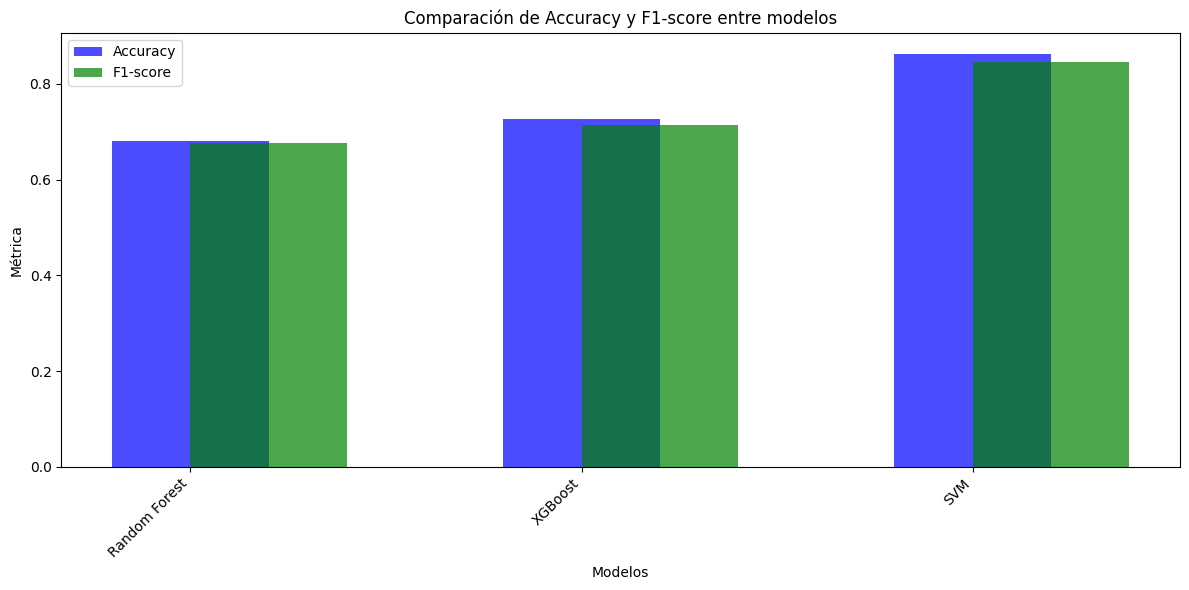

In [163]:
modelos = [modelo_random_forest, modelo_xgboost, modelo_svm]
nombres = ['Random Forest', 'XGBoost', 'SVM']

# Dividir los datos (si no lo has hecho antes)
X_train, X_test, y_train, y_test = train_test_split(
    datos_procesados, etiquetas, test_size=0.2, random_state=42
)

# Comparar y guardar el mejor modelo
comparar_y_guardar_modelo(modelos, nombres, X_test, y_test, '../models/modelo_clasificacion_actividades.pkl')